In [1]:
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


In [2]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

## Визуальный анализ ряда

In [3]:
data = pd.read_csv('WAG_C_M.csv', sep=';', index_col='month', parse_dates=['month'], dayfirst=True)

In [4]:
data

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5
...,...
2016-04-01,36497.0
2016-05-01,37270.0
2016-06-01,38447.0


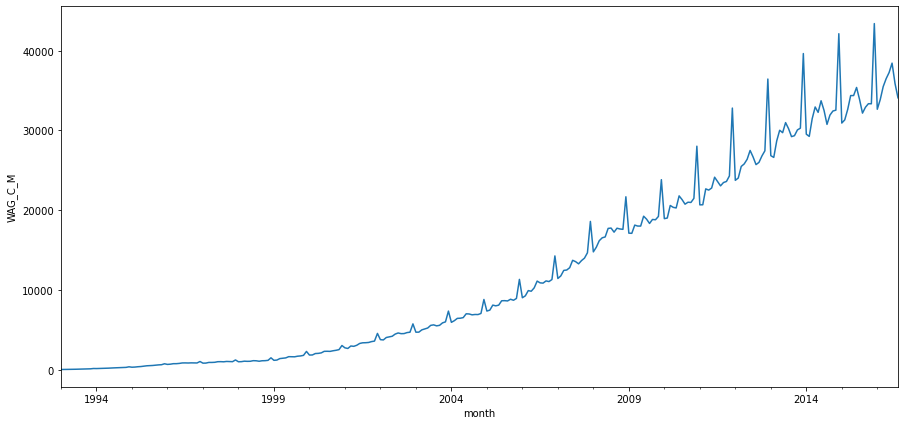

In [5]:
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
plt.ylabel('WAG_C_M')
pylab.show()

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

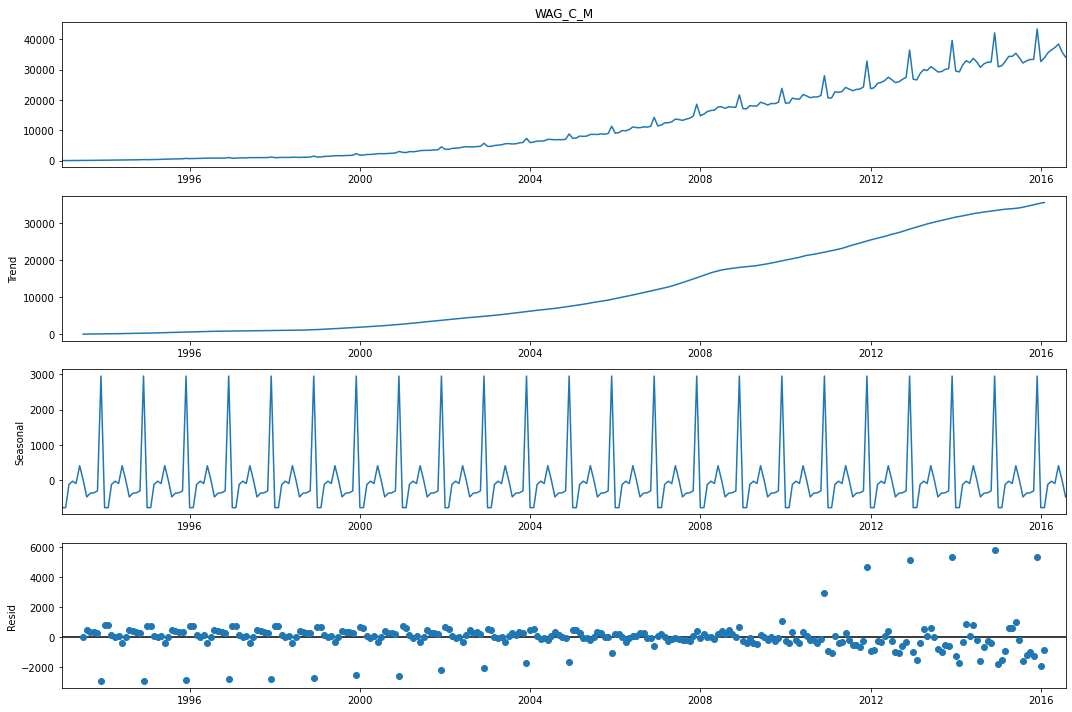

In [6]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M)[1])
pylab.show()

## Стабилизация дисперсии

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


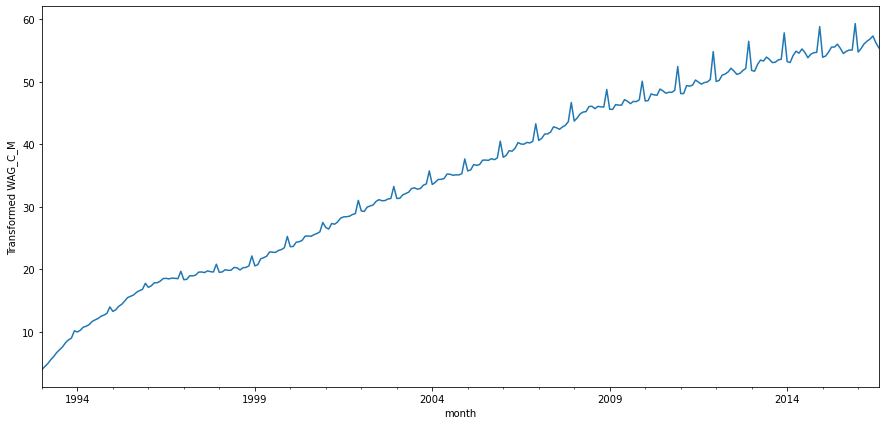

In [7]:
lmbda = stats.boxcox(data.WAG_C_M)
data['bc_wag'] = lmbda[0]
plt.figure(figsize(15,7))
data.bc_wag.plot()
plt.ylabel('Transformed WAG_C_M')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.bc_wag)[1])

## Выбор порядка дифференцирования

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

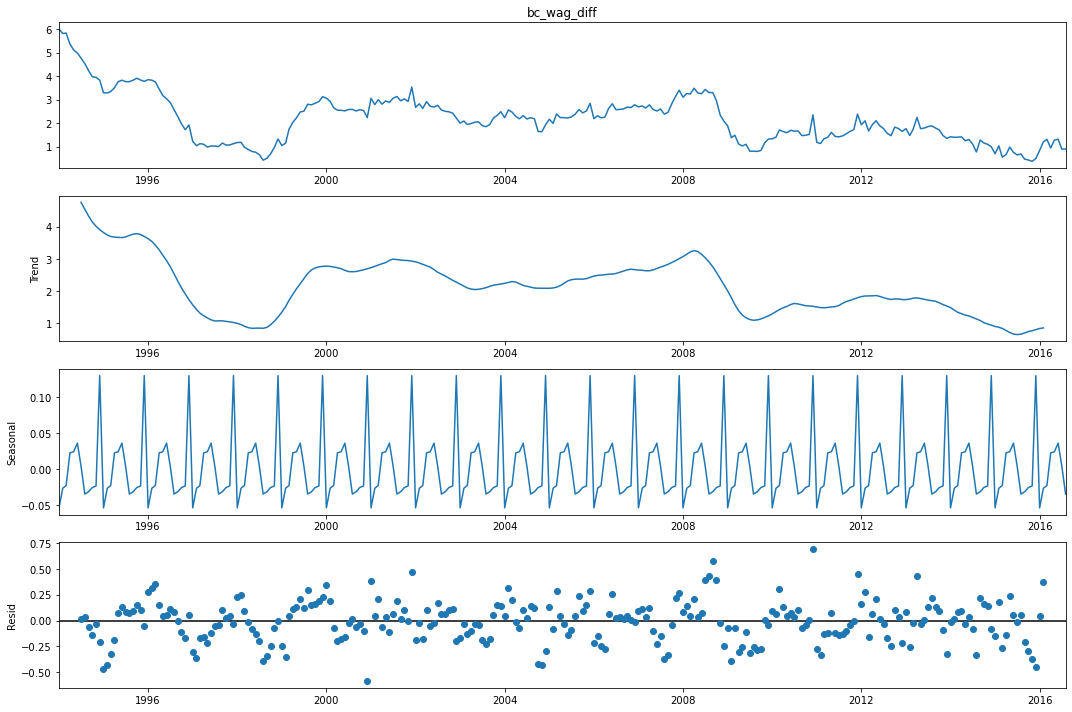

In [8]:
data['bc_wag_diff'] = data.bc_wag - data.bc_wag.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.bc_wag_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.bc_wag_diff[12:])[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем дифференцировать еще; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

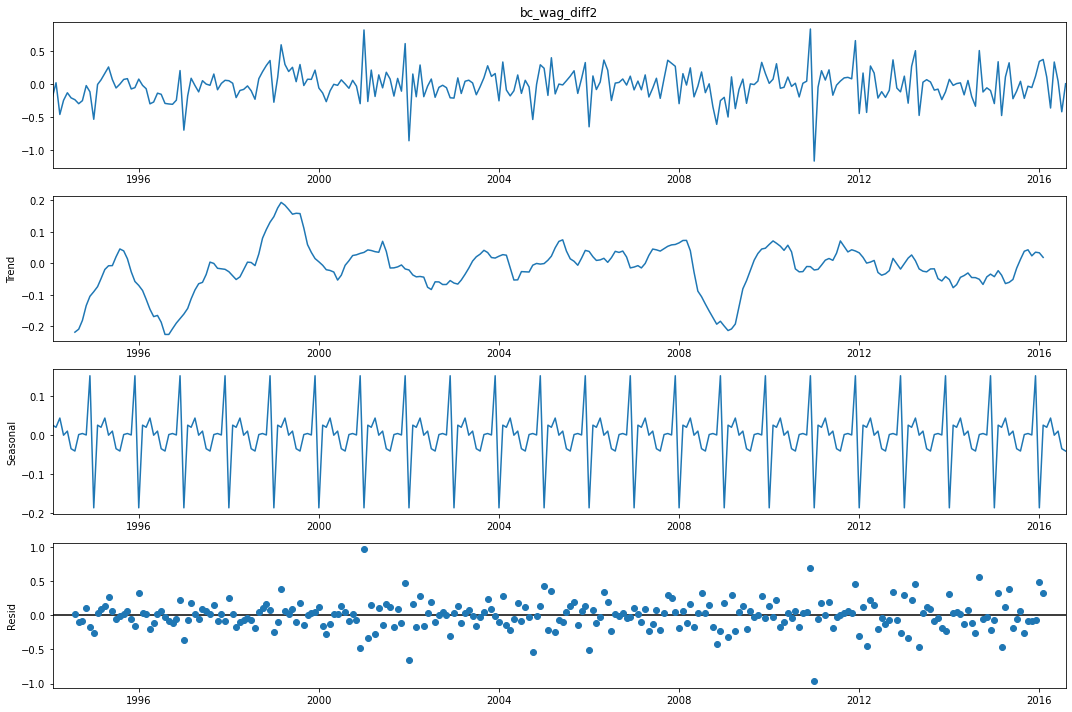

In [9]:
data['bc_wag_diff2'] = data.bc_wag_diff - data.bc_wag_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.bc_wag_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.bc_wag_diff2[13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет.

## Выбор начальных приближений для p,q,P,Q

In [11]:
data

,WAG_C_M,bc_wag,bc_wag_diff,bc_wag_diff2
month,,,,
1993-01-01,15.3,3.990393,NaN,NaN
1993-02-01,19.1,4.458758,NaN,NaN
1993-03-01,23.6,4.931635,NaN,NaN
1993-04-01,30.6,5.549430,NaN,NaN
1993-05-01,37.5,6.063406,NaN,NaN
...,...,...,...,...
2016-04-01,36497.0,56.526742,0.942729,-0.366210
2016-05-01,37270.0,56.860441,1.275065,0.332336
2016-06-01,38447.0,57.358885,1.316994,0.041929


<Figure size 1080x576 with 0 Axes>

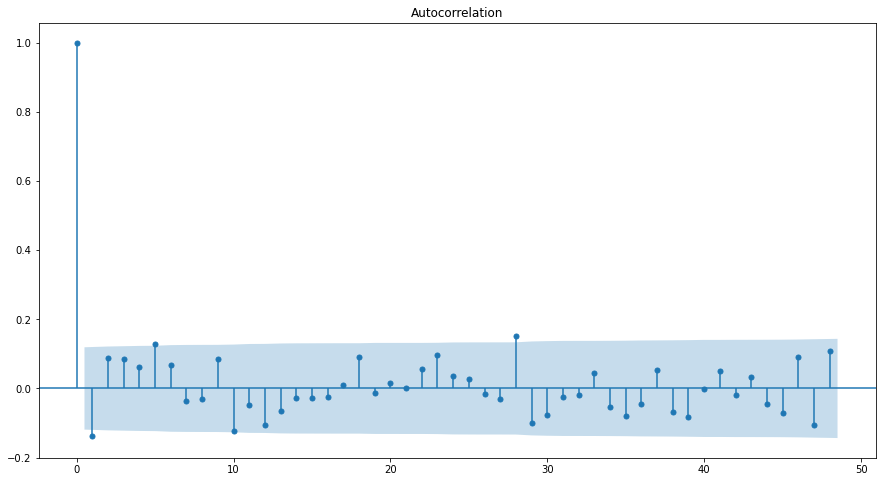

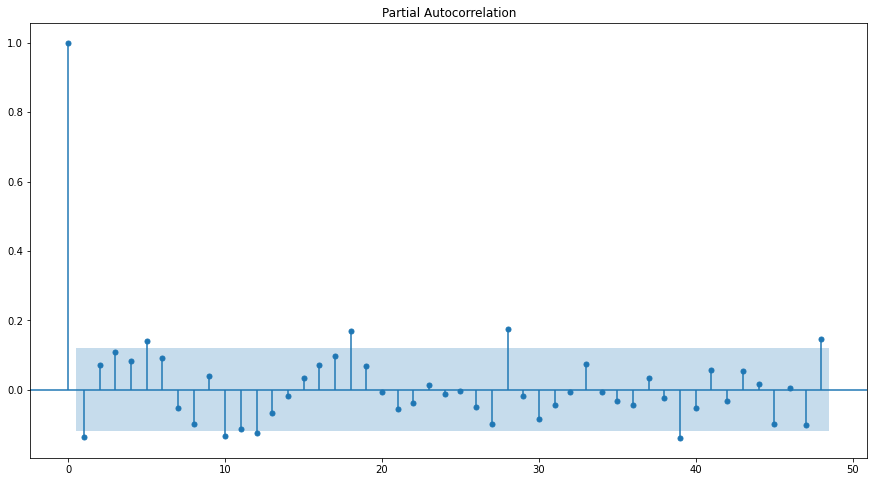

In [10]:
plt.figure(figsize(15,8))
sm.graphics.tsa.plot_acf(data.bc_wag_diff2[13:].values.squeeze(), lags=48)
sm.graphics.tsa.plot_pacf(data.bc_wag_diff2[13:].values.squeeze(), lags=48)
pylab.show()

Начальные приближения: Q=0, q=1, P=1, p=1

In [108]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

/Users/admin/anaconda3/envs/data/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [109]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

8

## Обучение и сравнение моделей-кандидатов, выбор победителя

In [110]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.bc_wag, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 3.77 s, sys: 905 ms, total: 4.67 s
Wall time: 651 ms


In [111]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters       aic
5  (1, 0, 1, 0)  0.340521
3  (0, 1, 1, 0)  1.170768
7  (1, 1, 1, 0)  2.021911
4  (1, 0, 0, 0)  2.625709
2  (0, 1, 0, 0)  3.369832


/Users/admin/anaconda3/envs/data/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [112]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             bc_wag   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Tue, 18 Jan 2022   AIC                              0.341
Time:                                    04:07:36   BIC                             11.147
Sample:                                01-01-1993   HQIC                             4.679
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1488      0.046     -3.210      0.001      -0.240      -0.058
ar.S.L12      -0.1314      0.046   

/Users/admin/anaconda3/envs/data/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Анализ остатков построенной модели

/Users/admin/anaconda3/envs/data/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


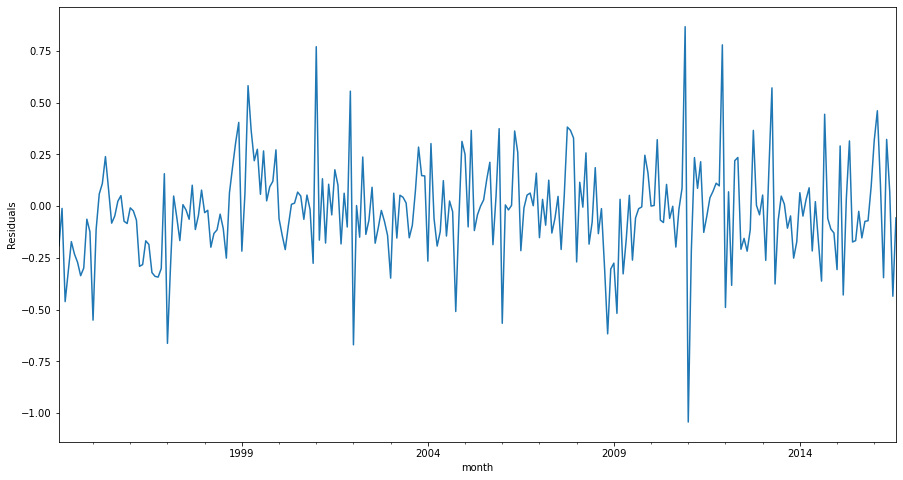

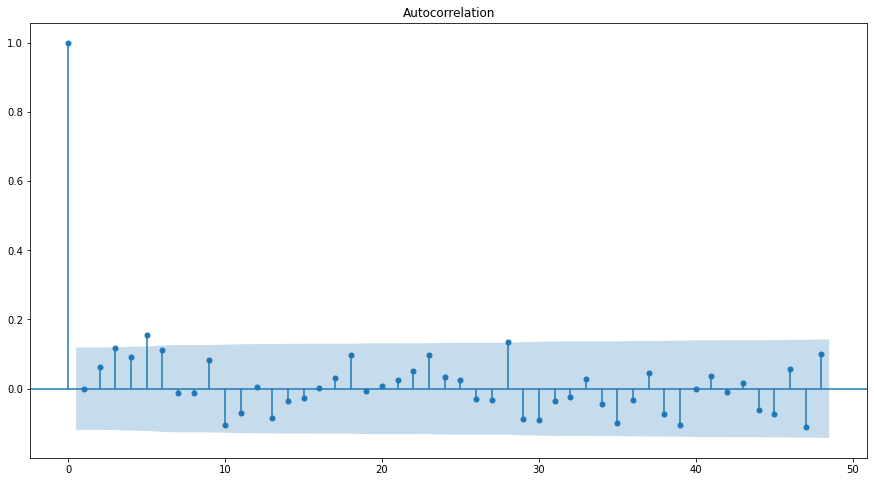

Критерий Стьюдента: p=0.090794
Критерий Дики-Фуллера: p=0.000003


In [117]:
plt.figure(figsize(15,8))
best_model.resid[13:].plot()
plt.ylabel('Residuals')

sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48)
pylab.show()

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой)

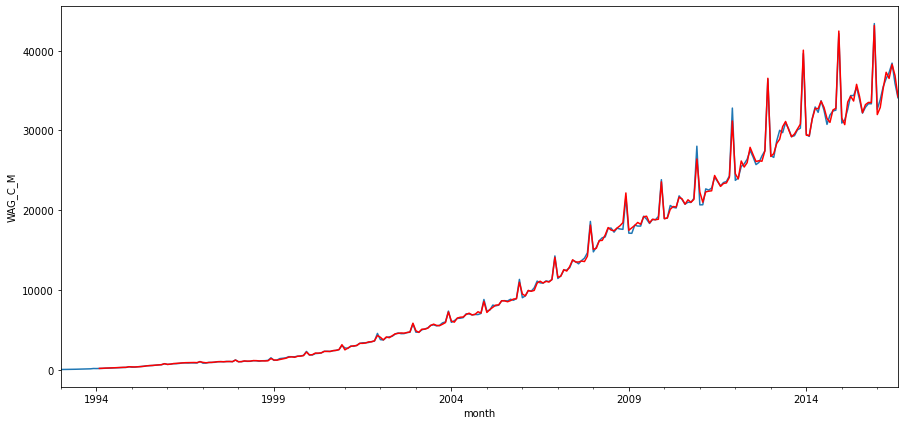

In [121]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda[1])
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
data.model[13:].plot(color='r')
plt.ylabel('WAG_C_M')
pylab.show()

## Прогнозирование с помощью финальной модели

/Users/admin/anaconda3/envs/data/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


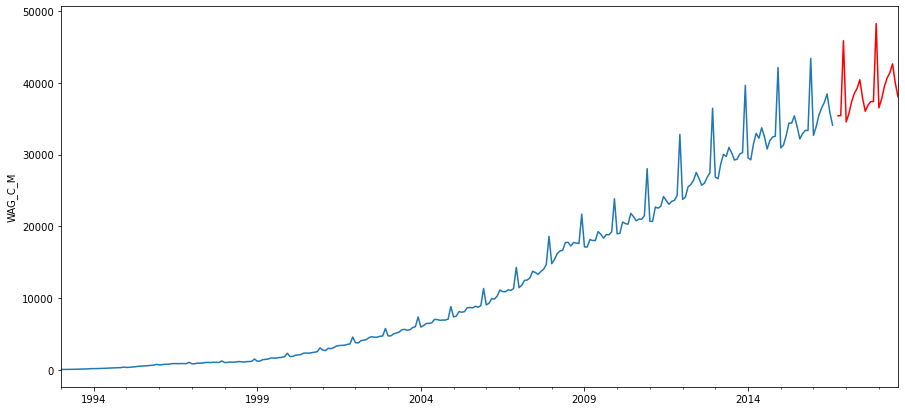

In [130]:
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=285, end=309), lmbda[1])

plt.figure(figsize(15,7))
data2.WAG_C_M.plot()
data2.forecast.plot(color='r')
plt.ylabel('WAG_C_M')
pylab.show()